# 1 Importations

Bibliothèques nécessaires

In [32]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf

import random




Définition d'un random state

In [2]:
#Définition du random state utilisé dans le notebook
random_state = 42

Importation des dataframes

In [3]:
%store -r df_KaggleData
%store -r df_NPD

In [4]:
df_NPD.head()

,Categorie,Plante,Maladie,Saine,Suffixe,Abrev,AbrevMaladie,Rotation,Luminosite,Symetrie,...,Mode,Profondeur de couleur,Moyenne R,Moyenne G,Moyenne B,Taille du fichier,Set,DirPath,FileName,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,109.957947,129.504242,119.117355,9606,valid,C:\Users\hadri\Plant project\data\1 New Plant ...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\hadri\Plant project\data\1 New Plant ...
1,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,110.123795,129.669220,119.235626,9960,valid,C:\Users\hadri\Plant project\data\1 New Plant ...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\hadri\Plant project\data\1 New Plant ...
2,Apple__Apple_scab,Apple,Apple_scab,0,new30degfliplr.jpg,FREC,Scab,30,0,LR,...,RGB,8,89.325546,109.759598,95.272110,10299,valid,C:\Users\hadri\Plant project\data\1 New Plant ...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\hadri\Plant project\data\1 New Plant ...
3,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,92.044342,125.152634,115.290207,11986,valid,C:\Users\hadri\Plant project\data\1 New Plant ...,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,C:\Users\hadri\Plant project\data\1 New Plant ...
4,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,129.272934,125.058243,113.740295,20194,valid,C:\Users\hadri\Plant project\data\1 New Plant ...,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Sc...,C:\Users\hadri\Plant project\data\1 New Plant ...


In [5]:
df_NPD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87863 entries, 0 to 87866
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Categorie              87863 non-null  object 
 1   Plante                 87863 non-null  object 
 2   Maladie                87863 non-null  object 
 3   Saine                  87863 non-null  int32  
 4   Suffixe                87863 non-null  object 
 5   Abrev                  87863 non-null  object 
 6   AbrevMaladie           87863 non-null  object 
 7   Rotation               87863 non-null  object 
 8   Luminosite             87863 non-null  object 
 9   Symetrie               87863 non-null  object 
 10  Hauteur                87863 non-null  int64  
 11  Largeur                87863 non-null  int64  
 12  Canaux                 87863 non-null  int64  
 13  Mode                   87863 non-null  object 
 14  Profondeur de couleur  87863 non-null  int64  
 15  Mo

# 2 Préparation des données

Sélection des colonnes utiles

In [6]:
df_model = df_NPD[['Categorie', 'Plante', 'Maladie', 'Saine', 'Set', 'FilePath']]

In [7]:
df_model.head()

,Categorie,Plante,Maladie,Saine,Set,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,valid,C:\Users\hadri\Plant project\data\1 New Plant ...
1,Apple__Apple_scab,Apple,Apple_scab,0,valid,C:\Users\hadri\Plant project\data\1 New Plant ...
2,Apple__Apple_scab,Apple,Apple_scab,0,valid,C:\Users\hadri\Plant project\data\1 New Plant ...
3,Apple__Apple_scab,Apple,Apple_scab,0,valid,C:\Users\hadri\Plant project\data\1 New Plant ...
4,Apple__Apple_scab,Apple,Apple_scab,0,valid,C:\Users\hadri\Plant project\data\1 New Plant ...


Création de 2 datasets train et valid

In [8]:
df_train = df_model[df_model['Set'] == 'train']
df_set_valid = df_model[df_model['Set'] == 'valid']

In [9]:
df_train.shape, df_set_valid.shape

((70292, 6), (17571, 6))

Création d'une fonction séparant un dataframe en 2 avec une proportion de x% tout en respectant l'équirépartition par catégorie

In [10]:
def evenly_split_df_by_x(df, x, cat):
    #Sépare un dataframe en 2 partie en respectant une proportion de x% des entrées dans le premier dataframe
    #Respecte la répartition des catégories dont l'intitulé de colonne est passé en argument
    #Retourne le dataframe contenant x% des lignes et le dataframe contenant le reste sous forme de tuple
    
    # Liste pour stocker les lignes sélectionnées
    list_select = []

    # Sélectionnez x% des lignes de chaque catégorie
    for category in df[cat].unique():
        temp_df = df[df[cat] == category]
        num_rows = round(len(temp_df) * x)
        sample_df = temp_df.sample(n=num_rows, random_state=random_state)
        list_select.append(sample_df)

    # Concaténez tous les dataframe dans la liste pour créer le premier dataframe
    df_select = pd.concat(list_select)
    
    # Créez le dataframe résiduel en supprimant les lignes sélectionnées
    df_rest = df.drop(df_select.index)
    
    return df_select, df_rest

Sélection de x% lignes du df valid à pour les validations pendant l'entrainement et conservation du reste pour les tests et les exemples

In [11]:
x = 0.80 #Pourcentage de lignes sélectionnées pour la validation
df_valid, df_test = evenly_split_df_by_x(df_set_valid, x, 'Categorie')

In [12]:
print(f"Nb lignes de train : {df_train.shape[0]}, nb lignes de valid {df_valid.shape[0]}, nb lignes de test {df_test.shape[0]}, proportion valid/train : {np.trunc(df_valid.shape[0]/df_train.shape[0]*100)}%")

Nb lignes de train : 70292, nb lignes de valid 14059, nb lignes de test 3512, proportion valid/train : 20.0%


Sélection aléatoire de x% lignes des dataframes train et valid pour l'entrainement et création des générateurs d'images

In [13]:
x = 0.4 #Pourcentage de lignes sélectionnées pour l'entrainement avec équirépartition des classes

df_train_sample = evenly_split_df_by_x(df_train, x, 'Categorie')[0]
df_valid_sample = evenly_split_df_by_x(df_valid, x, 'Categorie')[0]

In [14]:
print(f"Nb lignes de train : {df_train_sample.shape[0]}, nb lignes de valid {df_valid_sample.shape[0]}")

Nb lignes de train : 28117, nb lignes de valid 5624


Préparation des générateurs d'images

In [15]:
data_generator = ImageDataGenerator(rescale=1./255.)

In [16]:
batch_size = 64

In [17]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train_sample,
    x_col='FilePath',
    y_col='Categorie',
    batch_size=batch_size,
    seed=random_state,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

Found 28117 validated image filenames belonging to 38 classes.


In [18]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=df_valid_sample,
    x_col='FilePath',
    y_col='Categorie',
    batch_size=batch_size,
    seed=random_state,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

Found 5624 validated image filenames belonging to 38 classes.


# 3 Définitions et entrainements des modèles

## 3.1 Model LeNet du cours modifié en taille de fichiers d'entrées, classification au lieu de régression et 38 neuronnes de sortie

In [20]:
model_LeNet = Sequential()

model_LeNet.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape =  (256,256,3), padding = 'valid', kernel_regularizer=regularizers.l2(0.00001)))
model_LeNet.add(MaxPooling2D(pool_size = 2, strides = 2, padding = 'valid'))
model_LeNet.add(Dropout(rate = 0.5))
model_LeNet.add(Flatten())
model_LeNet.add(Dense(units = 38,activation = 'softmax'))

model_LeNet.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
model_LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 38)                19612902  
                                                                 
Total params: 19,613,798
Trainable params: 19,613,798
Non-trainable params: 0
____________________________________________

In [41]:
nb_img_train = train_generator.samples
nb_img_test = test_generator.samples

history_LeNet = model_LeNet.fit(train_generator, 
                                epochs = 10,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data = test_generator,
                                validation_steps = nb_img_test//batch_size
                                )

Epoch 1/10
439/439 [==============================] - 197s 448ms/step - loss: 4.7100 - accuracy: 0.5576 - val_loss: 0.9935 - val_accuracy: 0.7148
Epoch 2/10
439/439 [==============================] - 190s 432ms/step - loss: 0.4075 - accuracy: 0.8834 - val_loss: 0.8724 - val_accuracy: 0.7536
Epoch 3/10
439/439 [==============================] - 195s 444ms/step - loss: 0.1310 - accuracy: 0.9683 - val_loss: 0.7349 - val_accuracy: 0.7924
Epoch 4/10
439/439 [==============================] - 199s 454ms/step - loss: 0.0513 - accuracy: 0.9897 - val_loss: 0.8286 - val_accuracy: 0.7814
Epoch 5/10
439/439 [==============================] - 283s 645ms/step - loss: 0.0345 - accuracy: 0.9933 - val_loss: 0.9747 - val_accuracy: 0.7575
Epoch 6/10
439/439 [==============================] - 190s 433ms/step - loss: 0.0346 - accuracy: 0.9930 - val_loss: 0.8998 - val_accuracy: 0.7838
Epoch 7/10
439/439 [==============================] - 195s 443ms/step - loss: 0.0273 - accuracy: 0.9940 - val_loss: 0.9888 -

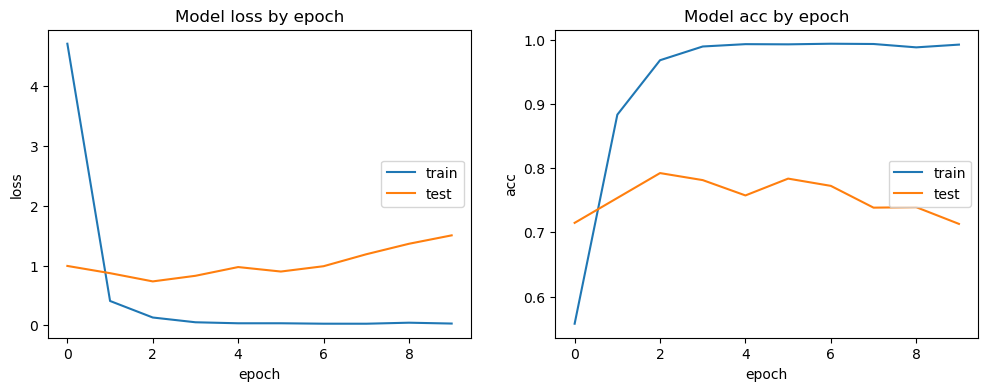

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_LeNet.history['loss'])
plt.plot(history_LeNet.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_LeNet.history['accuracy'])
plt.plot(history_LeNet.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [43]:
model_LeNet.save('model_LeNet.h5')

## 3.2 Modèle basé sur celui de l'examen 151.2

In [22]:
model_examen151_2 = Sequential()

model_examen151_2.add(Conv2D(name= 'conv2d_18', input_shape= (256,256,3), padding= 'valid', filters= 16, kernel_size= (3,3), activation= 'relu'))
model_examen151_2.add(MaxPooling2D(name= 'max_pooling2d_18', pool_size= 2))
model_examen151_2.add(Conv2D(name= 'conv2d_19', filters= 32, kernel_size= (3,3), padding= 'valid', activation= 'relu'))
model_examen151_2.add(MaxPooling2D(name= 'max_pooling2d_19', pool_size= 2))
model_examen151_2.add(Conv2D(name= 'conv2d_20', filters= 64, kernel_size= (3,3), padding= 'valid', activation= 'relu'))
model_examen151_2.add(MaxPooling2D(name= 'max_pooling2d_20', pool_size= 2))
model_examen151_2.add(Flatten(name= 'flatten_8'))
model_examen151_2.add(Dense(name= 'dense_16', units= 128))
model_examen151_2.add(Dense(name= 'dense_17', units= 38, activation= 'softmax'))

model_examen151_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model_examen151_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 64)      

In [45]:
history_examen151_2 =  model_examen151_2.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)

Epoch 1/10
440/440 [==============================] - 175s 397ms/step - loss: 1.6060 - accuracy: 0.5624 - val_loss: 0.9731 - val_accuracy: 0.6993
Epoch 2/10
440/440 [==============================] - 170s 387ms/step - loss: 0.5693 - accuracy: 0.8248 - val_loss: 0.6404 - val_accuracy: 0.7996
Epoch 3/10
440/440 [==============================] - 168s 381ms/step - loss: 0.2835 - accuracy: 0.9108 - val_loss: 0.6167 - val_accuracy: 0.8197
Epoch 4/10
440/440 [==============================] - 176s 400ms/step - loss: 0.1580 - accuracy: 0.9490 - val_loss: 0.6456 - val_accuracy: 0.8240
Epoch 5/10
440/440 [==============================] - 176s 399ms/step - loss: 0.1029 - accuracy: 0.9664 - val_loss: 0.7667 - val_accuracy: 0.8186
Epoch 6/10
440/440 [==============================] - 170s 385ms/step - loss: 0.0800 - accuracy: 0.9750 - val_loss: 0.7588 - val_accuracy: 0.8337
Epoch 7/10
440/440 [==============================] - 172s 390ms/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.8992 -

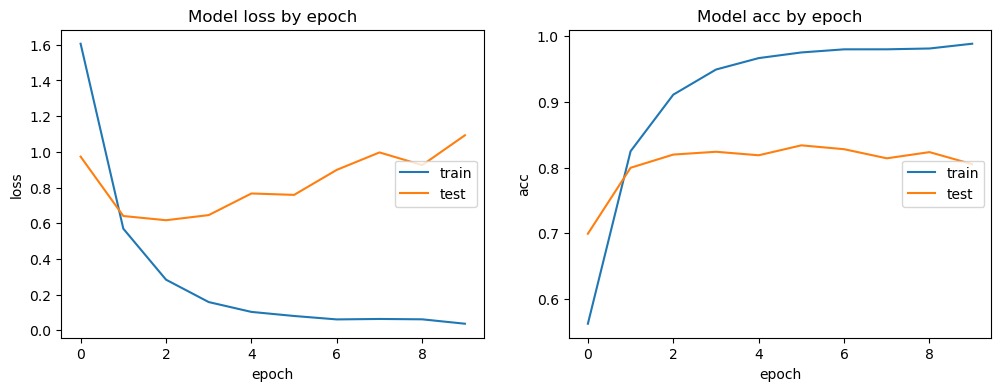

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_examen151_2.history['loss'])
plt.plot(history_examen151_2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_examen151_2.history['accuracy'])
plt.plot(history_examen151_2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [47]:
model_examen151_2.save('model_examen151_2.h5')

## 3.3 Modèle précédent amélioré avec couches de dropout

In [22]:
model_avec_dropout = Sequential()

model_avec_dropout.add(Conv2D(input_shape=(256,256,3), padding='valid', filters=16, kernel_size=(3,3), activation='relu', name='conv1'))
model_avec_dropout.add(MaxPooling2D(pool_size=2, name='pool1'))
model_avec_dropout.add(Dropout(0.25, name='dropout1'))

model_avec_dropout.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', name='conv2'))
model_avec_dropout.add(MaxPooling2D(pool_size=2, name='pool2'))
model_avec_dropout.add(Dropout(0.25, name='dropout2'))

model_avec_dropout.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu', name='conv3'))
model_avec_dropout.add(MaxPooling2D(pool_size=2, name='pool3'))
model_avec_dropout.add(Dropout(0.25, name='dropout3'))

model_avec_dropout.add(Flatten(name='flatten'))

model_avec_dropout.add(Dense(units=128, name='dense1'))
model_avec_dropout.add(Dropout(0.5, name='dropout4'))

model_avec_dropout.add(Dense(units=38, activation='softmax', name='output'))

model_avec_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model_avec_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 254, 254, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 127, 127, 16)      0         
                                                                 
 dropout1 (Dropout)          (None, 127, 127, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 125, 125, 32)      4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 62, 62, 32)        0         
                                                                 
 dropout2 (Dropout)          (None, 62, 62, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 64)       

In [49]:
history_avec_dropout =  model_avec_dropout.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)

Epoch 1/10
440/440 [==============================] - 214s 485ms/step - loss: 2.5373 - accuracy: 0.3502 - val_loss: 1.7465 - val_accuracy: 0.4918
Epoch 2/10
440/440 [==============================] - 216s 490ms/step - loss: 1.3557 - accuracy: 0.6033 - val_loss: 1.4351 - val_accuracy: 0.5798
Epoch 3/10
440/440 [==============================] - 211s 479ms/step - loss: 1.0438 - accuracy: 0.6910 - val_loss: 1.1250 - val_accuracy: 0.6599
Epoch 4/10
440/440 [==============================] - 205s 465ms/step - loss: 0.8432 - accuracy: 0.7457 - val_loss: 0.9768 - val_accuracy: 0.7038
Epoch 5/10
440/440 [==============================] - 204s 463ms/step - loss: 0.6849 - accuracy: 0.7906 - val_loss: 0.8777 - val_accuracy: 0.7319
Epoch 6/10
440/440 [==============================] - 214s 487ms/step - loss: 0.5851 - accuracy: 0.8171 - val_loss: 0.8045 - val_accuracy: 0.7486
Epoch 7/10
440/440 [==============================] - 219s 497ms/step - loss: 0.4876 - accuracy: 0.8478 - val_loss: 0.6134 -

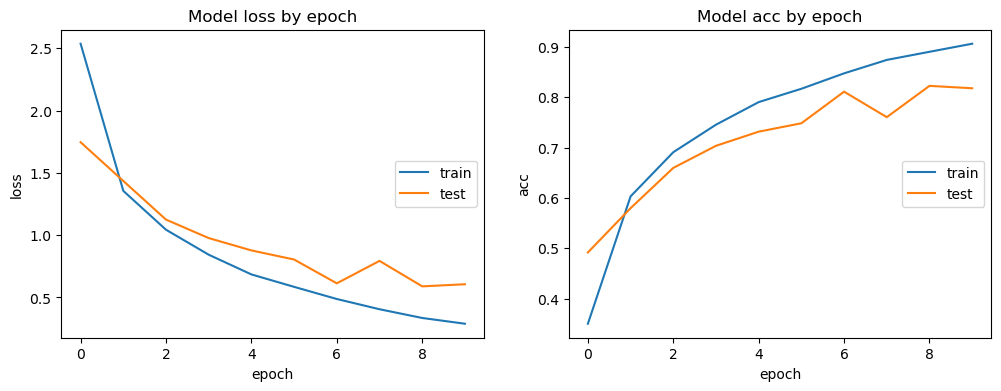

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_avec_dropout.history['loss'])
plt.plot(history_avec_dropout.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_avec_dropout.history['accuracy'])
plt.plot(history_avec_dropout.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [25]:
model_avec_dropout.save('model_avec_dropout.h5')

## 3.4 Même modèle avec dropouts plus faibles

In [3]:
model_avec_dropout2 = Sequential()

model_avec_dropout2.add(Conv2D(input_shape=(256,256,3), padding='valid', filters=16, kernel_size=(3,3), activation='relu', name='conv1'))
model_avec_dropout2.add(MaxPooling2D(pool_size=2, name='pool1'))
model_avec_dropout2.add(Dropout(0.2, name='dropout1'))

model_avec_dropout2.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', name='conv2'))
model_avec_dropout2.add(MaxPooling2D(pool_size=2, name='pool2'))
model_avec_dropout2.add(Dropout(0.2, name='dropout2'))

model_avec_dropout2.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu', name='conv3'))
model_avec_dropout2.add(MaxPooling2D(pool_size=2, name='pool3'))
model_avec_dropout2.add(Dropout(0.2, name='dropout3'))

model_avec_dropout2.add(Flatten(name='flatten'))

model_avec_dropout2.add(Dense(units=128, name='dense1'))
model_avec_dropout2.add(Dropout(0.3, name='dropout4'))

model_avec_dropout2.add(Dense(units=38, activation='softmax', name='output'))

model_avec_dropout2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
model_avec_dropout2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 254, 254, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 127, 127, 16)      0         
                                                                 
 dropout1 (Dropout)          (None, 127, 127, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 125, 125, 32)      4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 62, 62, 32)        0         
                                                                 
 dropout2 (Dropout)          (None, 62, 62, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 64)        1

In [54]:
history_avec_dropout2 =  model_avec_dropout2.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)

Epoch 1/10
440/440 [==============================] - 207s 470ms/step - loss: 2.2093 - accuracy: 0.4127 - val_loss: 1.1692 - val_accuracy: 0.6718
Epoch 2/10
440/440 [==============================] - 207s 471ms/step - loss: 1.0261 - accuracy: 0.6951 - val_loss: 0.9667 - val_accuracy: 0.7146
Epoch 3/10
440/440 [==============================] - 207s 470ms/step - loss: 0.7549 - accuracy: 0.7694 - val_loss: 0.8504 - val_accuracy: 0.7340
Epoch 4/10
440/440 [==============================] - 217s 492ms/step - loss: 0.5491 - accuracy: 0.8290 - val_loss: 0.6542 - val_accuracy: 0.7918
Epoch 5/10
440/440 [==============================] - 214s 486ms/step - loss: 0.3964 - accuracy: 0.8753 - val_loss: 0.5993 - val_accuracy: 0.8151
Epoch 6/10
440/440 [==============================] - 209s 475ms/step - loss: 0.2977 - accuracy: 0.9012 - val_loss: 0.5045 - val_accuracy: 0.8421
Epoch 7/10
440/440 [==============================] - 215s 489ms/step - loss: 0.2330 - accuracy: 0.9229 - val_loss: 0.4704 -

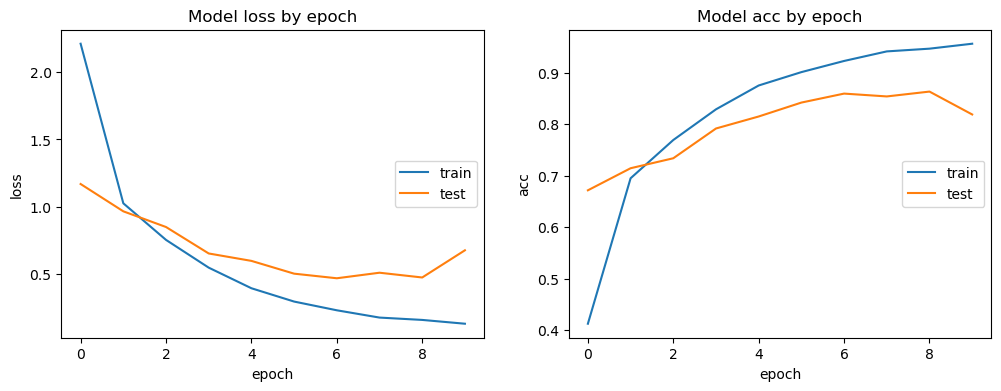

In [55]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_avec_dropout2.history['loss'])
plt.plot(history_avec_dropout2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_avec_dropout2.history['accuracy'])
plt.plot(history_avec_dropout2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [56]:
model_avec_dropout2.save('model_avec_dropout2.h5')

## 3.5 Modèle avec une couche de convolution supplémentaire

In [59]:
model_4_couches_conv = Sequential()

model_4_couches_conv.add(Conv2D(input_shape=(256,256,3), padding='valid', filters=16, kernel_size=(3,3), activation='relu', name='conv1'))
model_4_couches_conv.add(MaxPooling2D(pool_size=2, name='pool1'))
model_4_couches_conv.add(Dropout(0.2, name='dropout1'))

model_4_couches_conv.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', name='conv2'))
model_4_couches_conv.add(MaxPooling2D(pool_size=2, name='pool2'))
model_4_couches_conv.add(Dropout(0.2, name='dropout2'))

model_4_couches_conv.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu', name='conv3'))
model_4_couches_conv.add(MaxPooling2D(pool_size=2, name='pool3'))
model_4_couches_conv.add(Dropout(0.2, name='dropout3'))

model_4_couches_conv.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu', name='conv4'))
model_4_couches_conv.add(MaxPooling2D(pool_size=2, name='pool4'))
model_4_couches_conv.add(Dropout(0.2, name='dropout4'))

model_4_couches_conv.add(Flatten(name='flatten'))

model_4_couches_conv.add(Dense(units=256, name='dense1'))
model_4_couches_conv.add(Dropout(0.3, name='dropout5'))

model_4_couches_conv.add(Dense(units=38, activation='softmax', name='output'))

model_4_couches_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
history_4_couches_conv =  model_4_couches_conv.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)

Epoch 1/10


NotFoundError: Graph execution error:

Detected at node 'sequential_6/conv1/Relu' defined at (most recent call last):
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hadri\AppData\Local\Temp\ipykernel_29852\2382552272.py", line 1, in <module>
      history_4_couches_conv =  model_4_couches_conv.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\hadri\anaconda3\envs\DataScience\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_6/conv1/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17165440 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17165440 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 557844160 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 557844160 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16796416 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16796416 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 27570176 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 27570176 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 734010112 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 734010112 bytes.
	 [[{{node sequential_6/conv1/Relu}}]] [Op:__inference_train_function_8304]

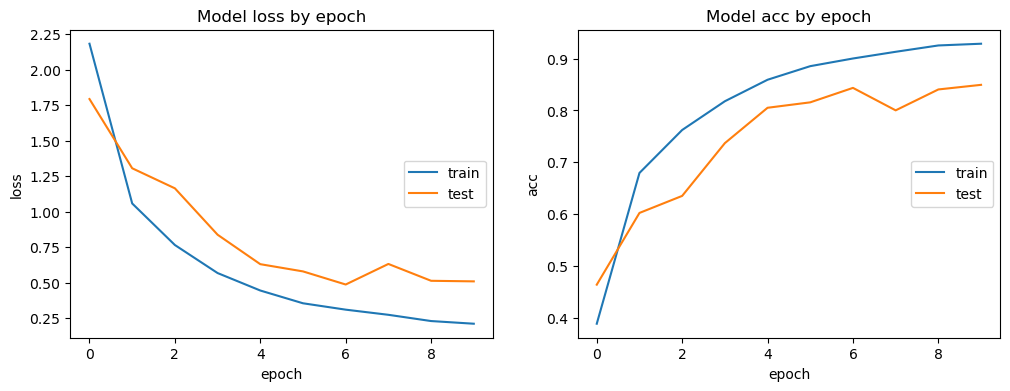

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_4_couches_conv.history['loss'])
plt.plot(history_4_couches_conv.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_4_couches_conv.history['accuracy'])
plt.plot(history_4_couches_conv.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [62]:
model_4_couches_conv.save('model_4_couches_conv.h5')

## 3.6 Modèle avec régularisation L1 et L2


In [5]:
model_avec_regularisation = Sequential()

model_avec_regularisation.add(Conv2D(input_shape=(256,256,3), 
                               padding='valid', 
                               filters=16, 
                               kernel_size=(3,3), 
                               activation='relu', 
                               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # Régularisation L1 et L2
                               name='conv1'))
model_avec_regularisation.add(MaxPooling2D(pool_size=2, name='pool1'))
model_avec_regularisation.add(Dropout(0.2, name='dropout1'))

model_avec_regularisation.add(Conv2D(filters=32, 
                               kernel_size=(3,3), 
                               padding='valid', 
                               activation='relu', 
                               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # Régularisation L1 et L2
                               name='conv2'))
model_avec_regularisation.add(MaxPooling2D(pool_size=2, name='pool2'))
model_avec_regularisation.add(Dropout(0.2, name='dropout2'))

model_avec_regularisation.add(Conv2D(filters=64, 
                               kernel_size=(3,3), 
                               padding='valid', 
                               activation='relu', 
                               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # Régularisation L1 et L2
                               name='conv3'))
model_avec_regularisation.add(MaxPooling2D(pool_size=2, name='pool3'))
model_avec_regularisation.add(Dropout(0.2, name='dropout3'))

model_avec_regularisation.add(Flatten(name='flatten'))

model_avec_regularisation.add(Dense(units=128, 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # Régularisation L1 et L2
                              name='dense1'))
model_avec_regularisation.add(Dropout(0.3, name='dropout4'))

model_avec_regularisation.add(Dense(units=38, 
                              activation='softmax', 
                              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # Régularisation L1 et L2
                              name='output'))

model_avec_regularisation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model_avec_regularisation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 254, 254, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 127, 127, 16)      0         
                                                                 
 dropout1 (Dropout)          (None, 127, 127, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 125, 125, 32)      4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 62, 62, 32)        0         
                                                                 
 dropout2 (Dropout)          (None, 62, 62, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 64)       

In [65]:
history_avec_regularisation =  model_avec_regularisation.fit(train_generator, validation_data= test_generator, epochs= 10, verbose= 1)

Epoch 1/10
440/440 [==============================] - 235s 533ms/step - loss: 20.6336 - accuracy: 0.0283 - val_loss: 12.3980 - val_accuracy: 0.0286
Epoch 2/10
440/440 [==============================] - 227s 515ms/step - loss: 12.3623 - accuracy: 0.0272 - val_loss: 12.2622 - val_accuracy: 0.0286
Epoch 3/10
440/440 [==============================] - 227s 515ms/step - loss: 12.2865 - accuracy: 0.0281 - val_loss: 12.4080 - val_accuracy: 0.0288
Epoch 4/10
440/440 [==============================] - 231s 525ms/step - loss: 12.3530 - accuracy: 0.0281 - val_loss: 12.3065 - val_accuracy: 0.0288
Epoch 5/10
440/440 [==============================] - 237s 538ms/step - loss: 12.4510 - accuracy: 0.0281 - val_loss: 12.6177 - val_accuracy: 0.0288
Epoch 6/10
440/440 [==============================] - 248s 563ms/step - loss: 12.6413 - accuracy: 0.0274 - val_loss: 12.7100 - val_accuracy: 0.0288
Epoch 7/10
440/440 [==============================] - 234s 532ms/step - loss: 12.6632 - accuracy: 0.0278 - val_l

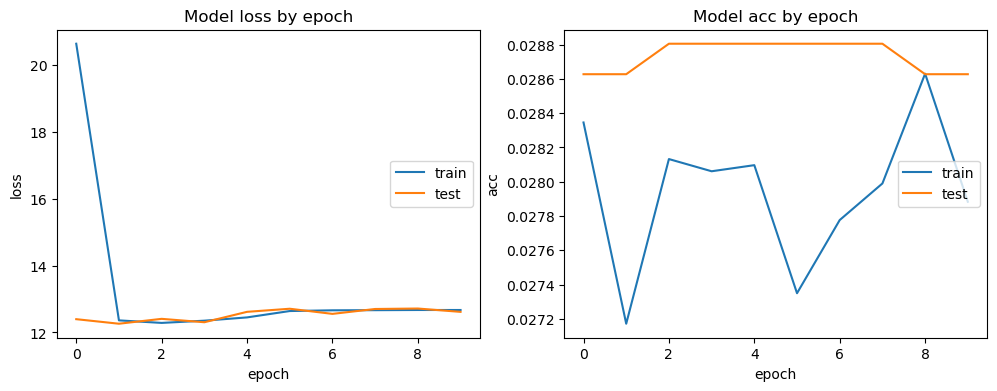

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_avec_regularisation.history['loss'])
plt.plot(history_avec_regularisation.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_avec_regularisation.history['accuracy'])
plt.plot(history_avec_regularisation.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [67]:
model_avec_regularisation.save('model_avec_regularisation.h5')

# 4 Analyse des modèles

Chargement des poids des modèles (la structure doit être préchargée)

In [19]:
model_LeNet = load_model('model_LeNet.h5')
model_examen151_2 = load_model('model_examen151_2.h5')
model_avec_dropout = load_model('model_avec_dropout.h5')
model_avec_dropout2 = load_model('model_avec_dropout2.h5')
model_4_couches_conv = load_model('model_4_couches_conv.h5')

Préparation du générateur d'images de validation

In [20]:
validFull_generator = data_generator.flow_from_dataframe(
    dataframe=df_set_valid,
    x_col='FilePath',
    y_col='Categorie',
    batch_size=16,
    seed=random_state,
    shuffle=False,  # Important pour avoir les vraies étiquettes dans le bon ordre
    class_mode="categorical",
    target_size=(256,256))

Found 17571 validated image filenames belonging to 38 classes.


## 4.1 Model LeNet

In [21]:
# Obtenir les prédictions du modèle
predictions = model_LeNet.predict(validFull_generator)
predicted_classes = np.argmax(predictions, axis=1)

1099/1099 [==============================] - 31s 26ms/step


In [22]:
# Obtenir les vraies classes
true_classes = validFull_generator.classes
class_labels = list(validFull_generator.class_indices.keys())  

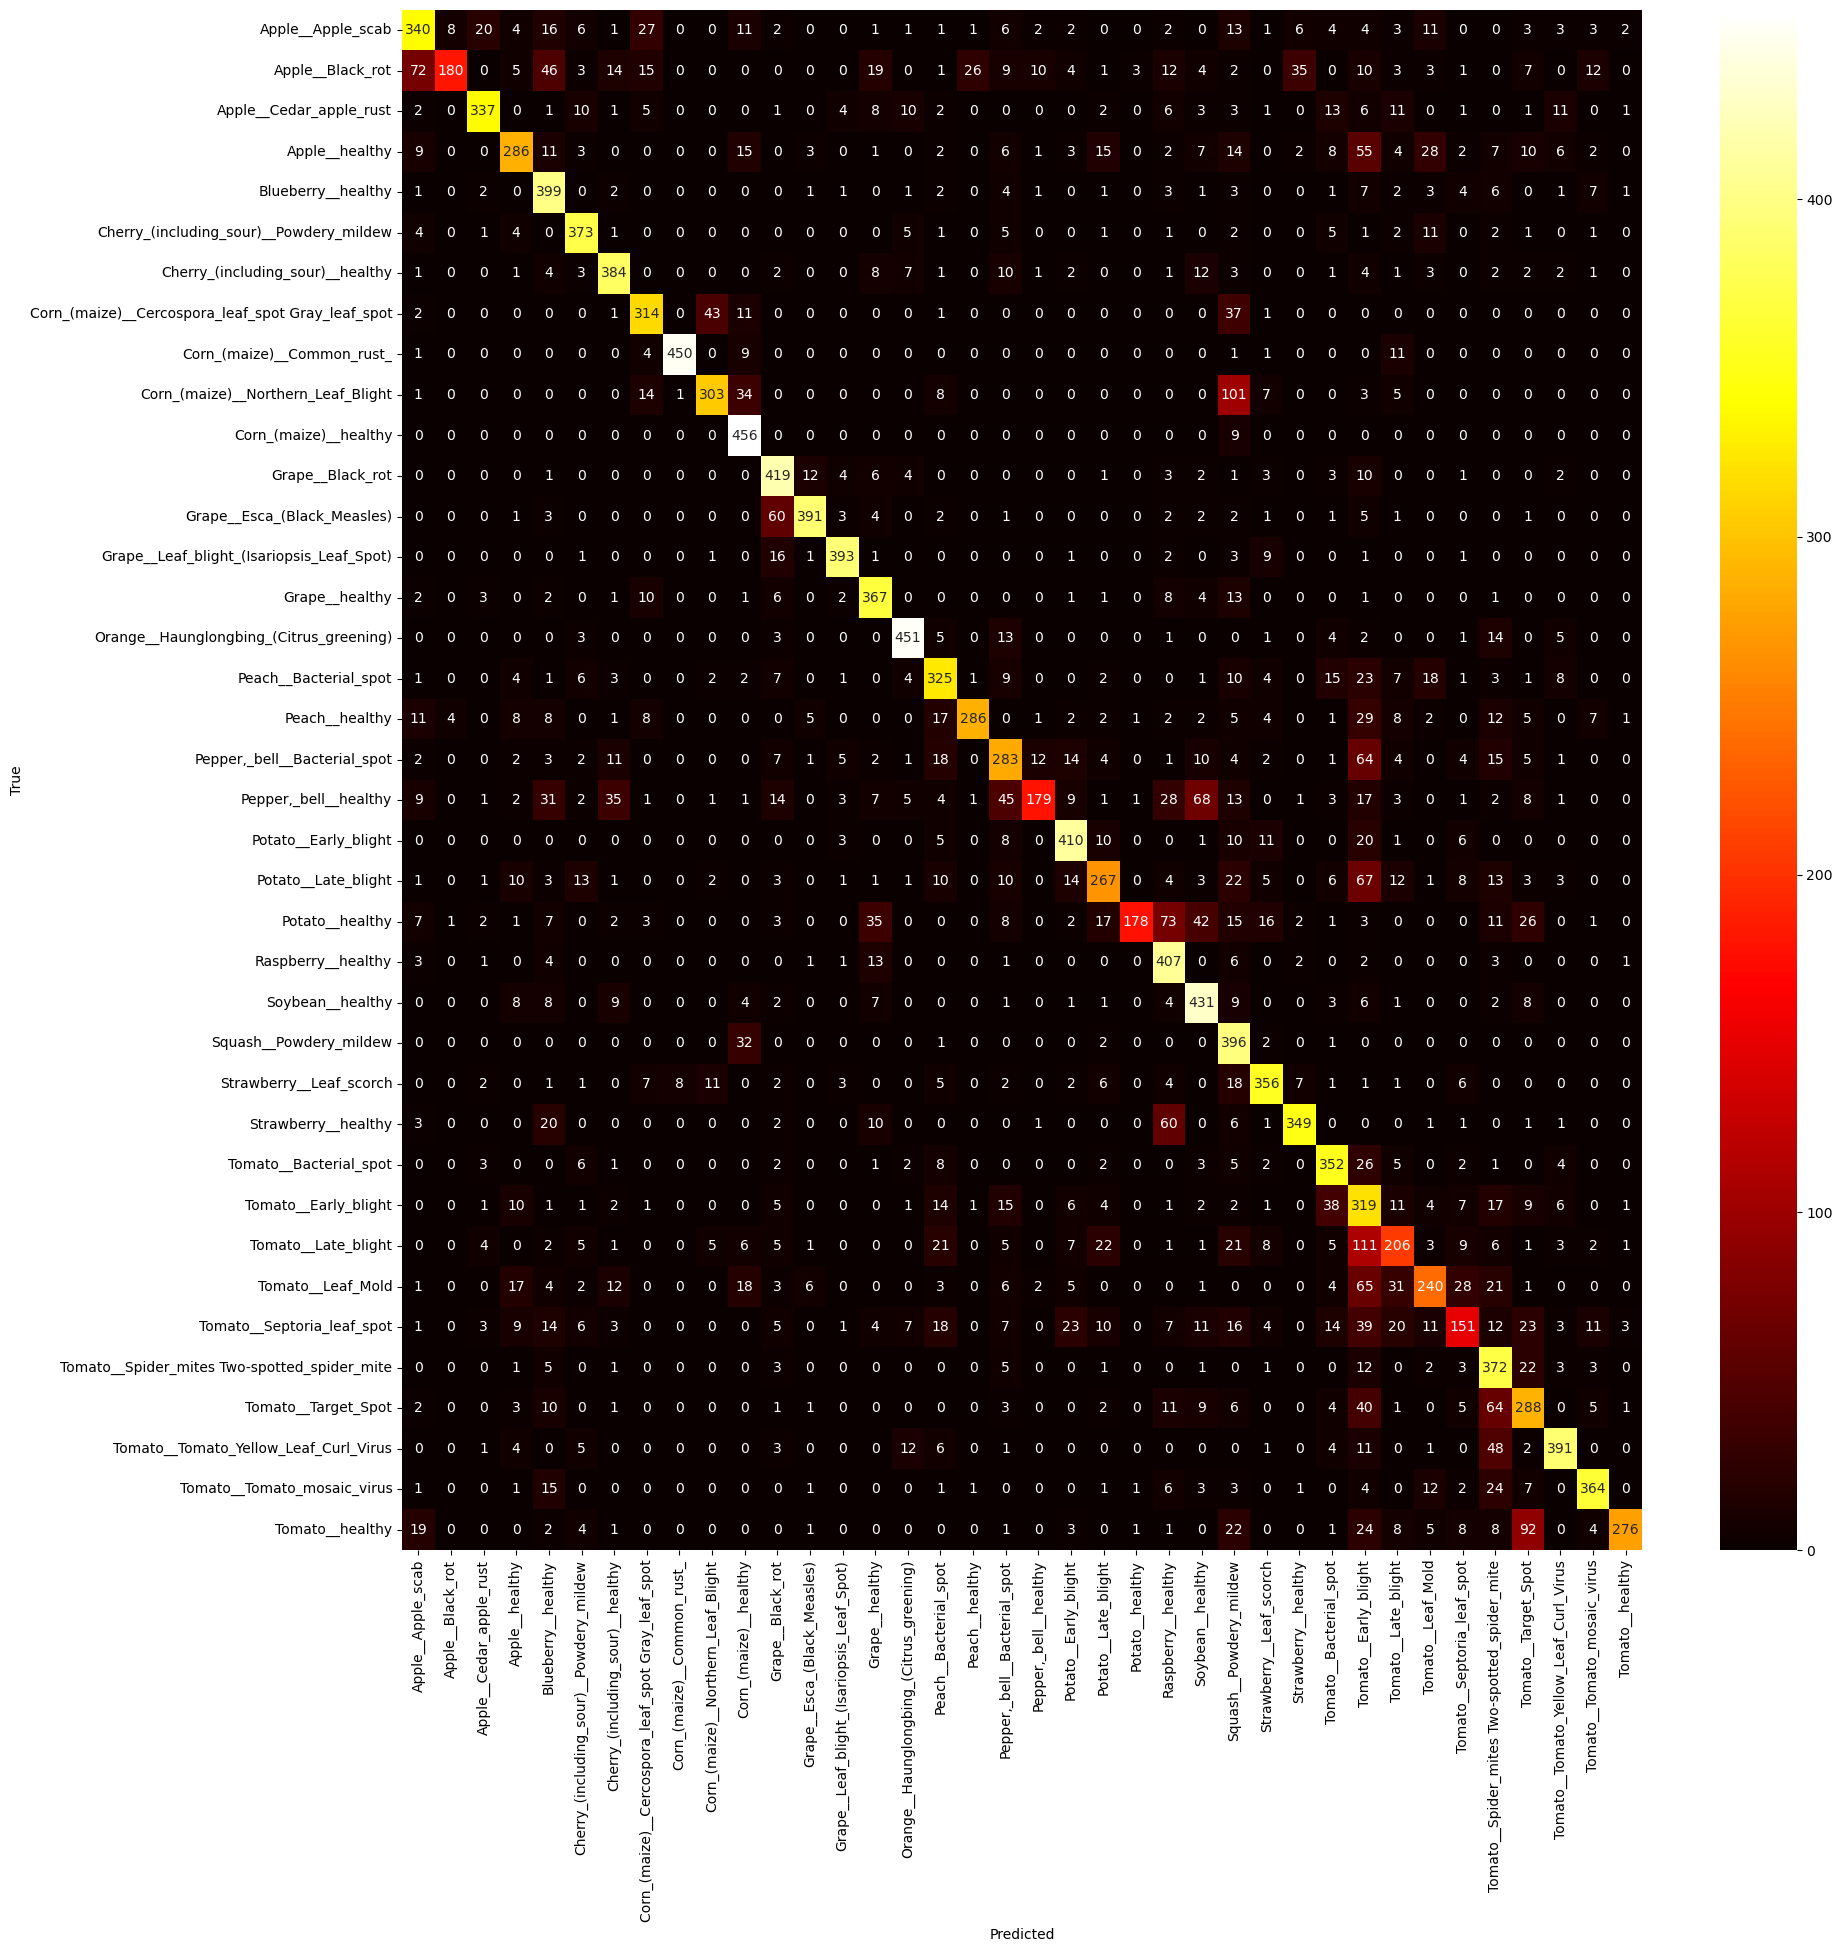

In [23]:
# Créer la matrice de confusion
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 

# Calcul de la matrice de confusion en pourcentages
confusion_mtx_percent = confusion_mtx / confusion_mtx.sum(axis=1, keepdims=True) * 100

# Créer une heatmap de la matrice de confusion
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
# Créer le rapport de classification
class_labels = list(validFull_generator.class_indices.keys())  # Obtenir les noms des classes
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                                                   precision    recall  f1-score   support

                                Apple__Apple_scab       0.69      0.67      0.68       504
                                 Apple__Black_rot       0.93      0.36      0.52       497
                          Apple__Cedar_apple_rust       0.88      0.77      0.82       440
                                   Apple__healthy       0.75      0.57      0.65       502
                               Blueberry__healthy       0.64      0.88      0.74       454
          Cherry_(including_sour)__Powdery_mildew       0.82      0.89      0.85       421
                 Cherry_(including_sour)__healthy       0.79      0.84      0.81       456
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.77      0.77      0.77       410
                       Corn_(maize)__Common_rust_       0.98      0.94      0.96       477
               Corn_(maize)__Northern_Leaf_Blight       0.82      0.64      0.72       47

## 4.1 Model avec Dropouts 2

In [25]:
# Obtenir les prédictions du modèle
predictions = model_avec_dropout2.predict(validFull_generator)
predicted_classes = np.argmax(predictions, axis=1)

1099/1099 [==============================] - 30s 27ms/step


In [26]:
# Obtenir les vraies classes
true_classes = validFull_generator.classes
class_labels = list(validFull_generator.class_indices.keys())  

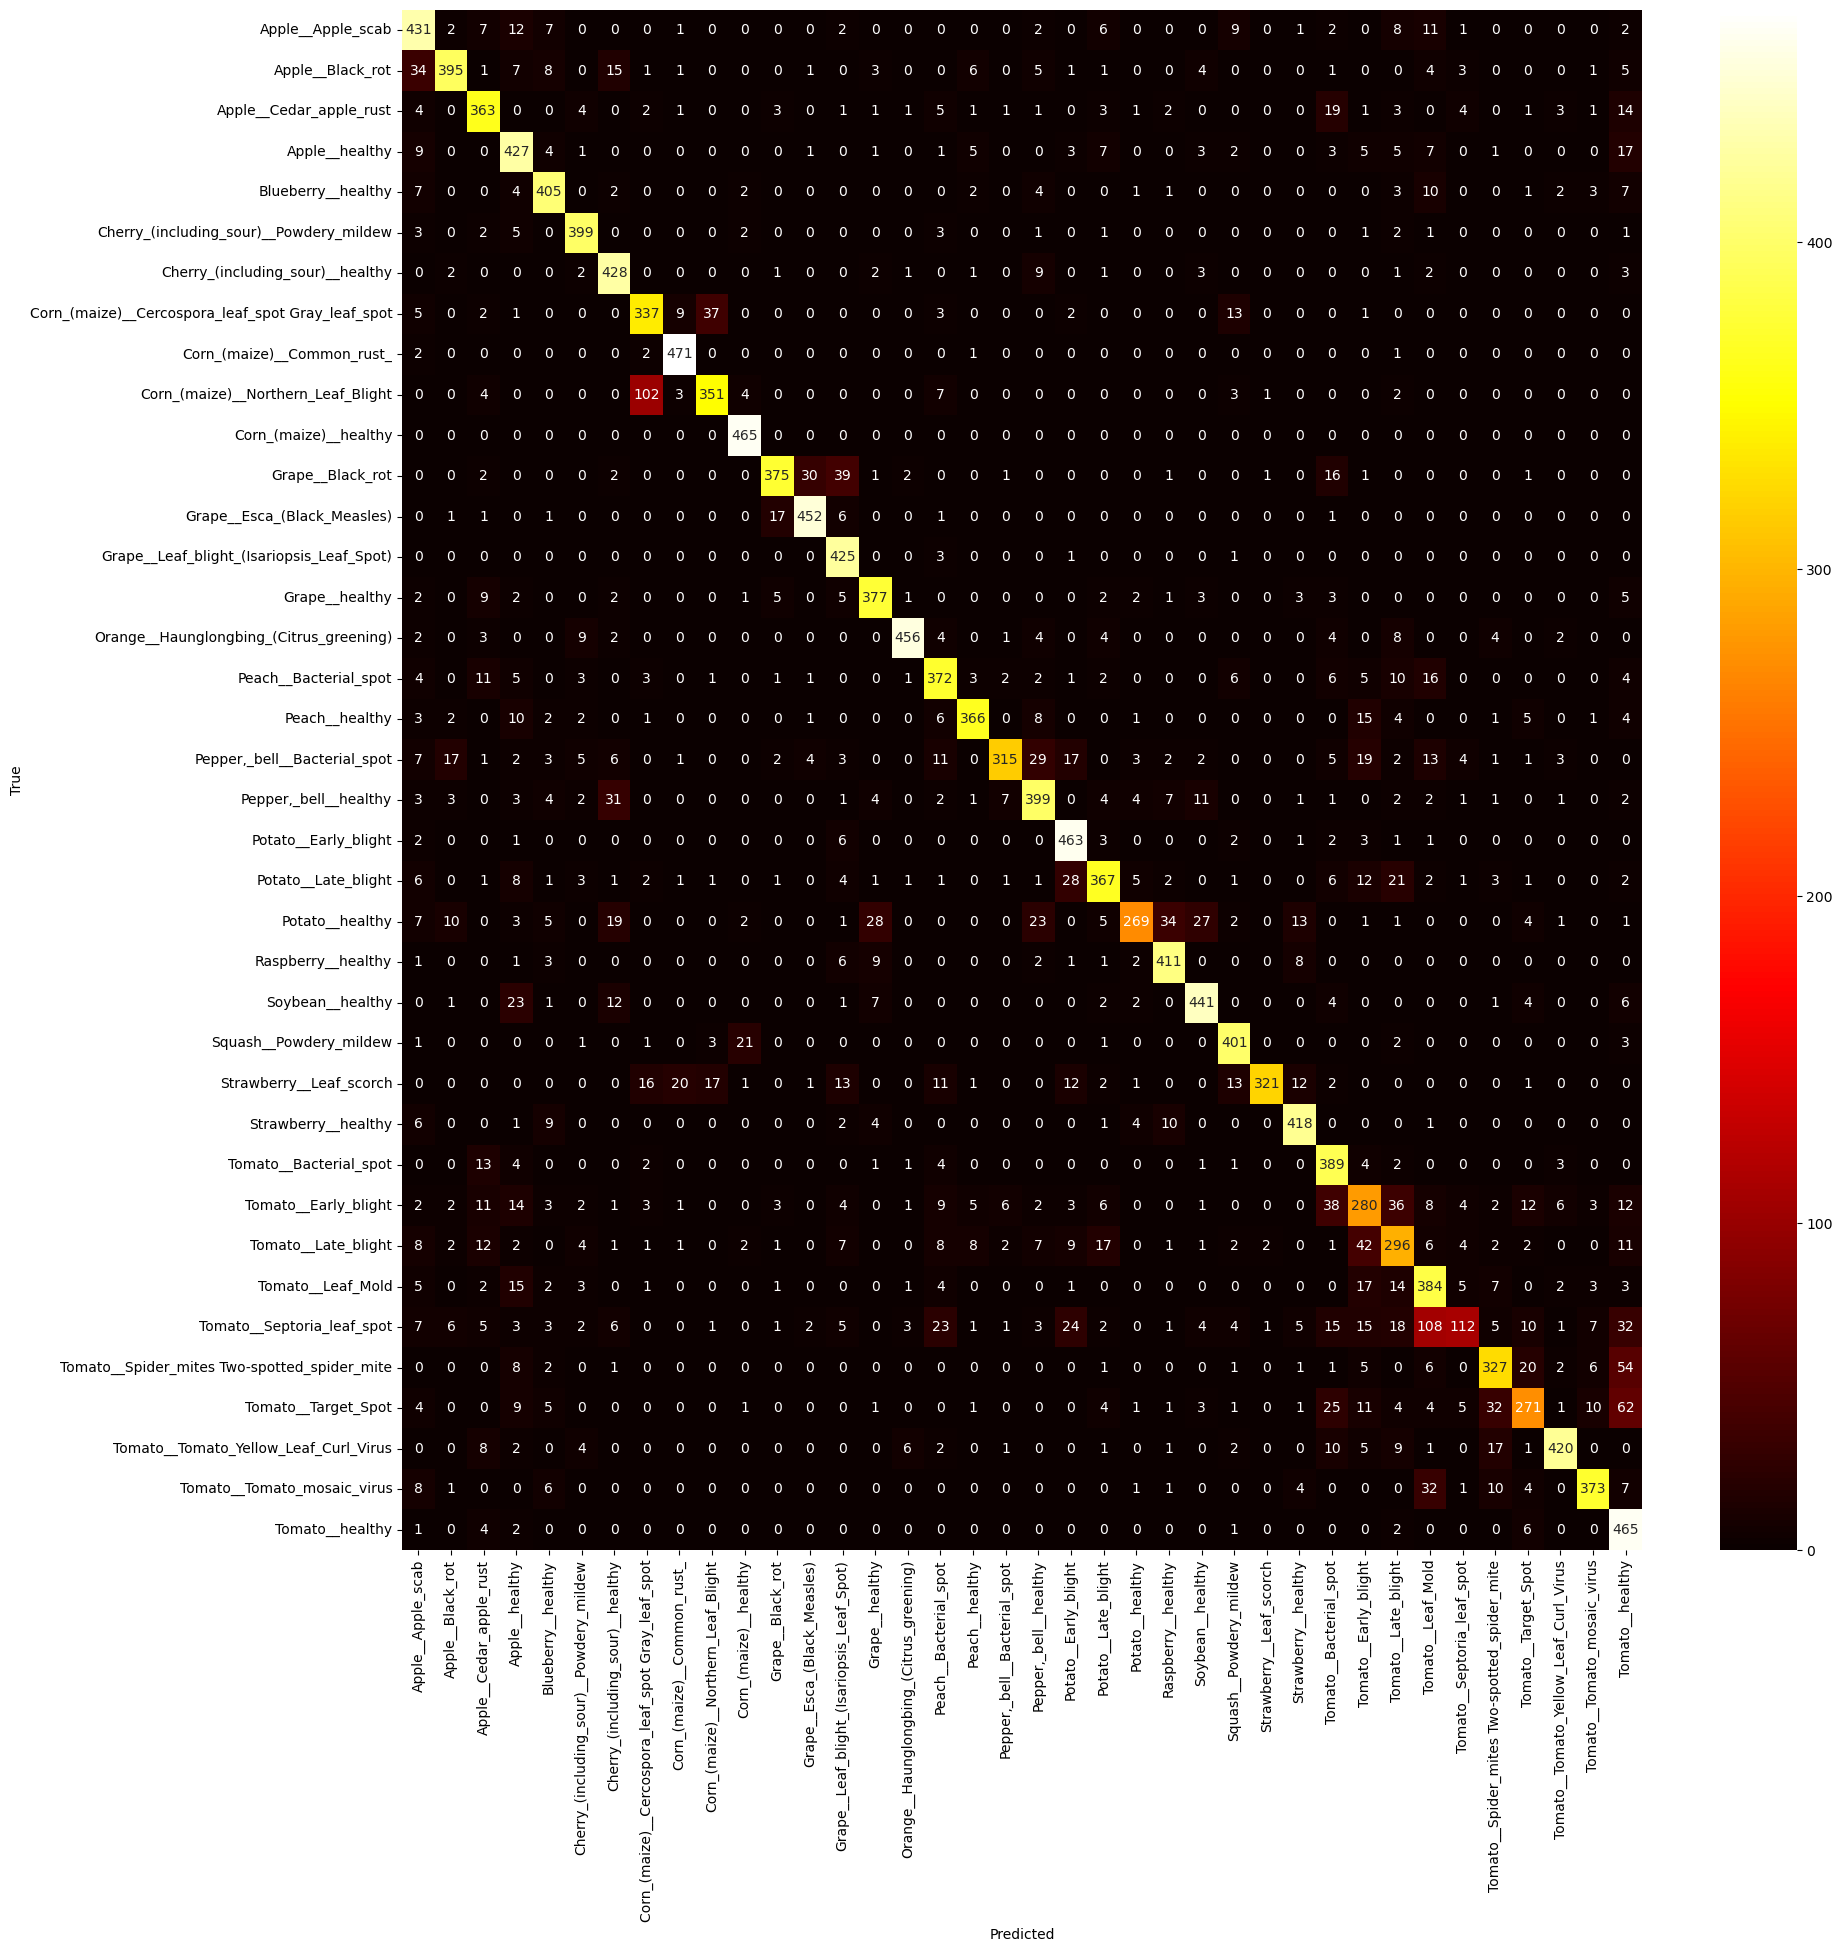

In [27]:
# Créer la matrice de confusion
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 

# Calcul de la matrice de confusion en pourcentages
confusion_mtx_percent = confusion_mtx / confusion_mtx.sum(axis=1, keepdims=True) * 100

# Créer une heatmap de la matrice de confusion
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Créer le rapport de classification
class_labels = list(validFull_generator.class_indices.keys())  # Obtenir les noms des classes
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                                                   precision    recall  f1-score   support

                                Apple__Apple_scab       0.75      0.86      0.80       504
                                 Apple__Black_rot       0.89      0.79      0.84       497
                          Apple__Cedar_apple_rust       0.79      0.82      0.80       440
                                   Apple__healthy       0.74      0.85      0.79       502
                               Blueberry__healthy       0.85      0.89      0.87       454
          Cherry_(including_sour)__Powdery_mildew       0.89      0.95      0.92       421
                 Cherry_(including_sour)__healthy       0.81      0.94      0.87       456
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.71      0.82      0.76       410
                       Corn_(maize)__Common_rust_       0.92      0.99      0.95       477
               Corn_(maize)__Northern_Leaf_Blight       0.85      0.74      0.79       47

1/1 [==============================] - 0s 23ms/step


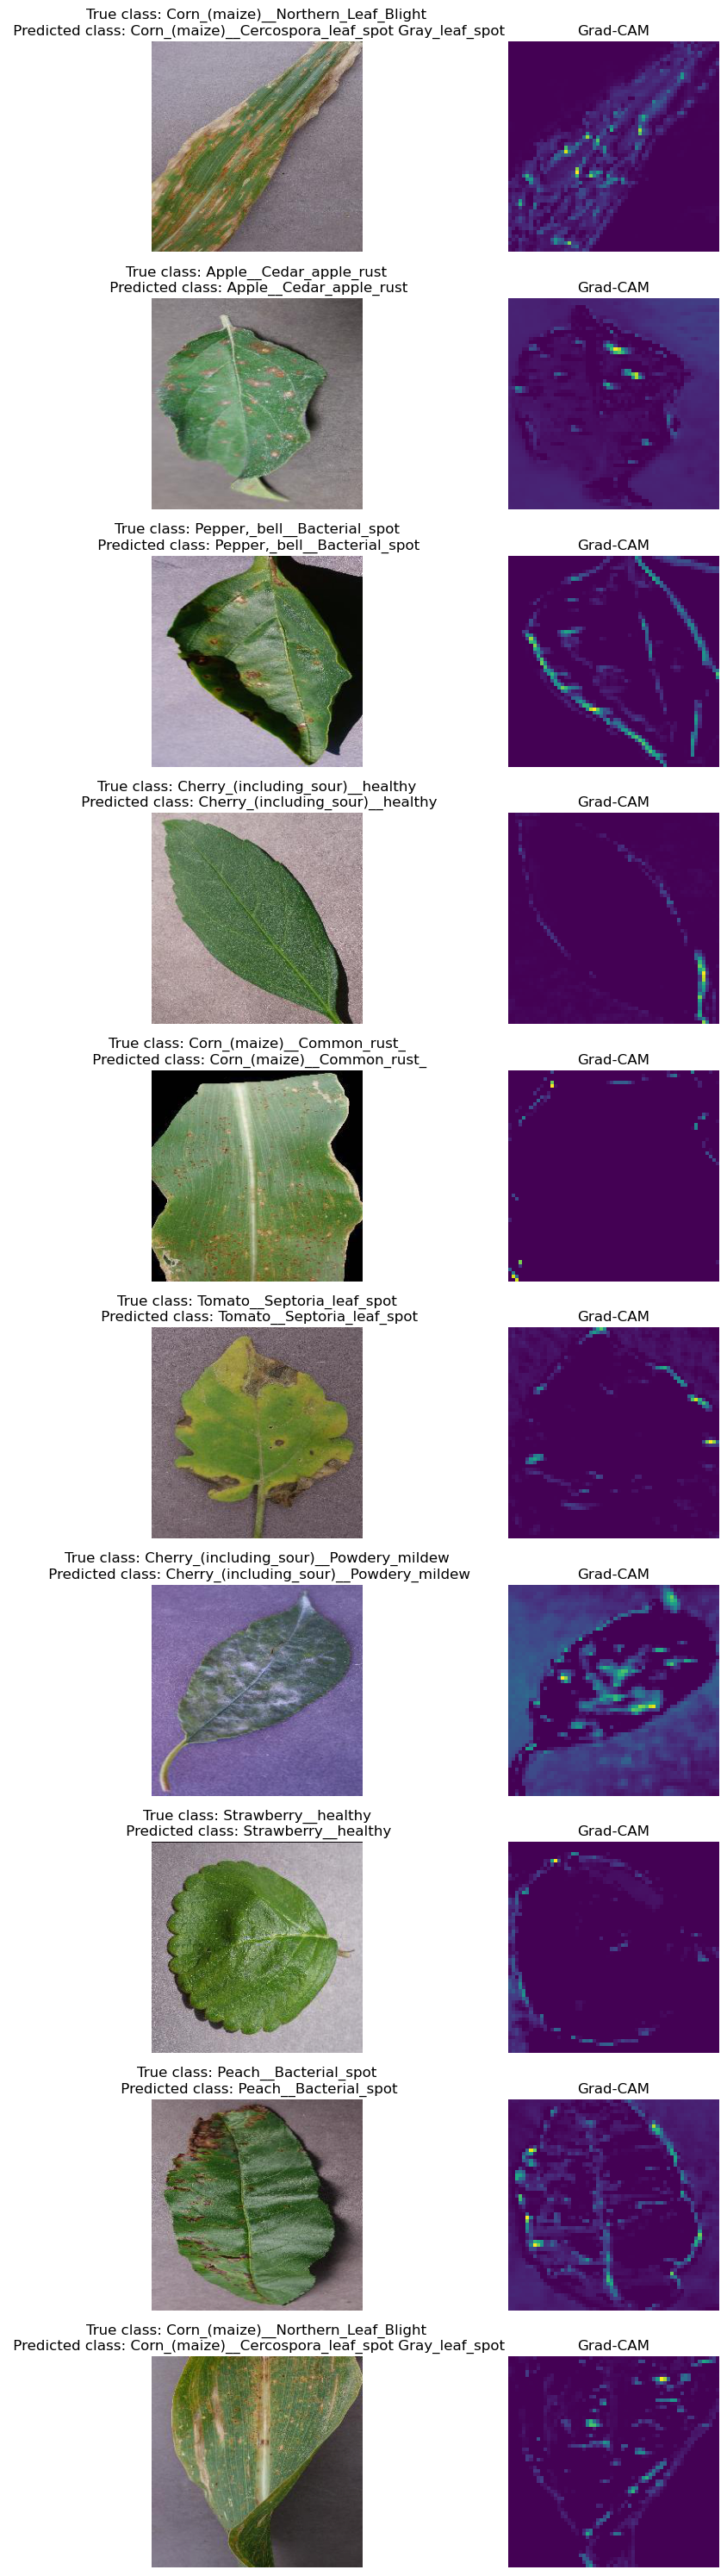

In [36]:
# Sélectionnez 10 indices aléatoires à partir de l'ensemble de validation
random_indices = random.sample(range(len(validFull_generator.filepaths)), 10)

# Créer un modèle qui mappe les entrées du modèle initial aux activations de la dernière couche de convolution
last_conv_layer = model_avec_dropout2.get_layer('conv3')
grad_model = Model([model_avec_dropout2.inputs], [last_conv_layer.output, model_avec_dropout2.output])

# Obtenir les vraies classes
class_labels = list(validFull_generator.class_indices.keys())

fig, axs = plt.subplots(10, 2, figsize=(10, 30))  # On a modifié les dimensions pour avoir 10 lignes et 2 colonnes

for i, idx in enumerate(random_indices):
    # Charger l'image
    image = load_img(validFull_generator.filepaths[idx], target_size=(256, 256))
    image = img_to_array(image)
    image /= 255.
    image_copy = np.copy(image)  # On conserve une copie de l'image originale pour l'afficher plus tard
    image = np.expand_dims(image, axis=0)
    
    # Obtenir la classe réelle
    true_class = validFull_generator.classes[idx]
    
    # Obtenir les prédictions du modèle
    predictions = model_avec_dropout2.predict(image)
    predicted_class = np.argmax(predictions, axis=1)

    # Obtenir les gradients de la classe prédite par rapport aux sorties de la dernière couche de convolution
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplier chaque canal de la carte de caractéristiques par "l'importance" de ce canal pour la classe prédite
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    heatmap = heatmap.squeeze()

    # Affichage
    axs[i, 0].imshow(image_copy)
    axs[i, 0].set_title(f"True class: {class_labels[true_class]}\n Predicted class: {class_labels[predicted_class[0]]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(heatmap)
    axs[i, 1].set_title("Grad-CAM")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()